In [7]:
# basic
import os
import pathlib
import random
import shutil
from typing import Dict, List, Tuple
# viz
import matplotlib.pyplot as plt
from PIL import Image
# torch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
# torchvision
import torchvision
from torchvision import transforms, datasets
# torchmetrics
from torchmetrics import ConfusionMatrix
# from torchmetrics.classification import MulticlassAccuracy
from mlxtend.plotting import plot_confusion_matrix
# misc
from tqdm.auto import tqdm
# custom
from src import utils, engine, data_setup

In [8]:
# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.1'

In [9]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Preparation

1. Make training, validation and testing folder
1. Move 70% of the data to training folder
1. Move 20% of the data to validation folder
1. Move 10% of the data to testing folder

Folder structure after this process

```
data
    └─── EuroSAT_MS
        ├─── train
        |   └─── AnnualCrop
        |   |   ├─── AnnualCrop_1.jpg
        |   |   ├─── AnnualCrop_2.jpg
        |   |   └─── ...
        |   ├─── Forest
        |   |   ├─── Forest_1.jpg
        |   |   ├─── Forest_2.jpg
        |   |   └─── ...
        ├─── valid
        |   └─── AnnualCrop
        |   |   ├─── AnnualCrop_3.jpg
        |   |   ├─── AnnualCrop_4.jpg
        |   |   └─── ...
        |   ├─── Forest
        |   |   ├─── Forest_3.jpg
        |   |   ├─── Forest_4.jpg
        |   |   └─── ...
        └─── test
            └─── AnnualCrop
            |   ├─── AnnualCrop_1.jpg
            |   ├─── AnnualCrop_2.jpg
            |   └─── ...
            └─── Forest
                ├─── Forest_1.jpg
                ├─── Forest_2.jpg
                └─── ...
```

In [10]:
RANDOM_SEED = 42
BATCH_SIZE = 64

## Make a function to reorganize the folder

In [11]:
# Prepare the folder and its name
root_dir = os.getcwd()
root_dir = pathlib.Path(root_dir)

data_path = root_dir / "data"
original_eurosat_path = data_path / "EuroSAT"
new_eurosat_path = data_path / "EuroSAT_reorganized"

# Setup train, valid, and testing paths
train_path = new_eurosat_path / "train"
valid_path = new_eurosat_path / "valid"
test_path = new_eurosat_path / "test"

# put all the class names inside a list
class_name = os.listdir(original_eurosat_path)
print(class_name, len(class_name))

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'] 10


In [12]:
# Specify the source and destination folders
source_folder = original_eurosat_path
destination_folder = new_eurosat_path

# Specify the train, valid, and test ratios
train_ratio = 0.6
valid_ratio = 0.2

# Reorganize the folder structure
try:
    utils.reorganize_folder_structure(
        source_folder, 
        destination_folder, 
        train_ratio, 
        valid_ratio
        )
except:
    print("Folders already exist")

Folders already exist


## Check the result

PermanentCrop


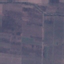

In [13]:
temp_class = random.choice(class_name)
index = random.randint(0,600)
print(temp_class)
Image.open(train_path / temp_class / os.listdir(train_path / temp_class)[index])

# Turn the data into a DataLoader

In [14]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = datasets.ImageFolder(root=valid_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT = train_dataset[0][0].shape[0], train_dataset[0][0].shape[1], train_dataset[0][0].shape[2]
print(IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT)

3 64 64


(-0.5, 63.5, 63.5, -0.5)

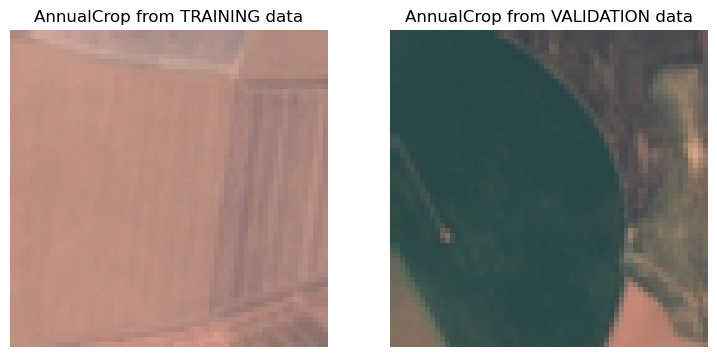

In [16]:
# check the data from train and valid dataset
fig = plt.figure(figsize=(9, 9))

img, label = train_dataset[index]
fig.add_subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_name[label]} from TRAINING data")
plt.axis(False)

img, label = valid_dataset[index]
fig.add_subplot(1, 2, 2)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_name[label]} from VALIDATION data")
plt.axis(False)

# Training

## EfficientNet_B0

In [17]:
def create_enb0(infeatures=1280, classes=class_name):
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Model Modification
    # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the manual seeds
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(classes)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True), 
        torch.nn.Linear(in_features=infeatures, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)).to(device)
    
    return model

In [19]:
model_enb0 = create_enb0()

In [12]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_enb0,
        input_size=(BATCH_SIZE, IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 64, 64]      [64, 10]             --                   Partial
├─Sequential (features)                                      [64, 3, 64, 64]      [64, 1280, 2, 2]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 64, 64]      [64, 32, 32, 32]     --                   False
│    │    └─Conv2d (0)                                       [64, 3, 64, 64]      [64, 32, 32, 32]     (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 32, 32]     [64, 32, 32, 32]     (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 32, 32]     [64, 32, 32, 32]     --                   --
│    └─Sequential (1)                                        [64, 32, 32, 32]     [64, 

### Training Process

In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_enb0.parameters(), lr=0.001)

In [14]:
# Setup training and save the results
EPOCH = 5
# metric = MulticlassAccuracy(num_classes=len(class_name)).to(device)

results = engine.train(
    model=model_enb0,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCH,
    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9223 | train_acc: 0.7117 | test_loss: 0.6869 | test_acc: 0.7920
Epoch: 2 | train_loss: 0.6418 | train_acc: 0.7931 | test_loss: 0.5825 | test_acc: 0.8084
Epoch: 3 | train_loss: 0.6131 | train_acc: 0.7982 | test_loss: 0.6832 | test_acc: 0.8121
Epoch: 4 | train_loss: 0.5902 | train_acc: 0.8038 | test_loss: 0.5653 | test_acc: 0.8187
Epoch: 5 | train_loss: 0.5785 | train_acc: 0.8060 | test_loss: 0.6355 | test_acc: 0.8202


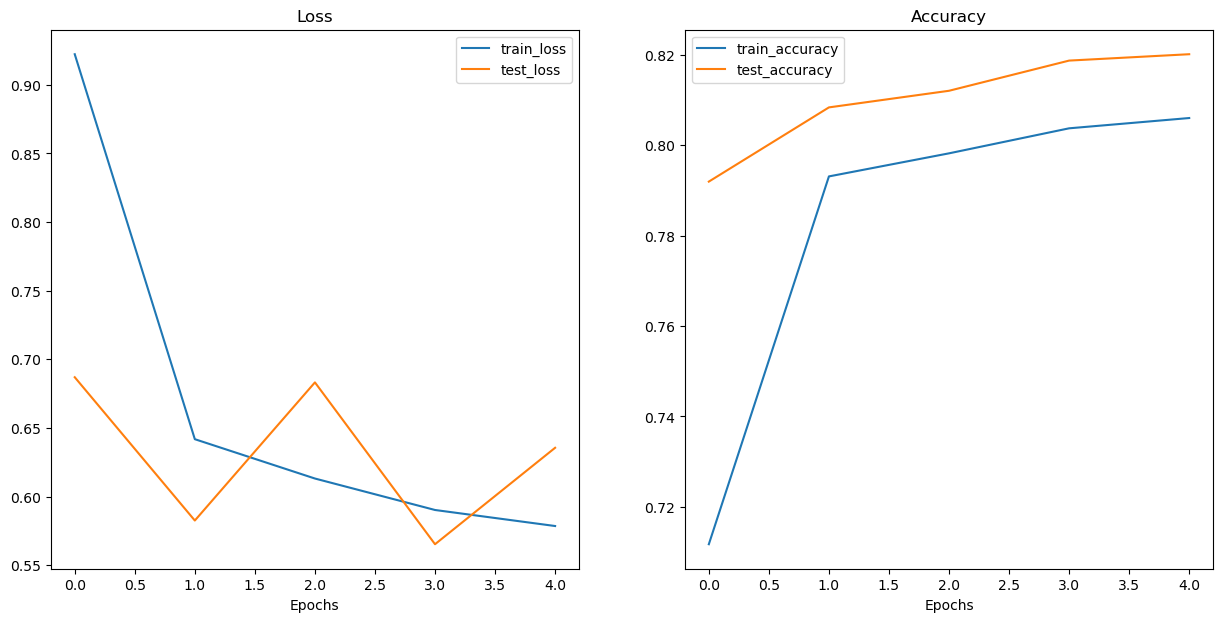

In [15]:
utils.plot_loss_curves(results)

### Make Prediction

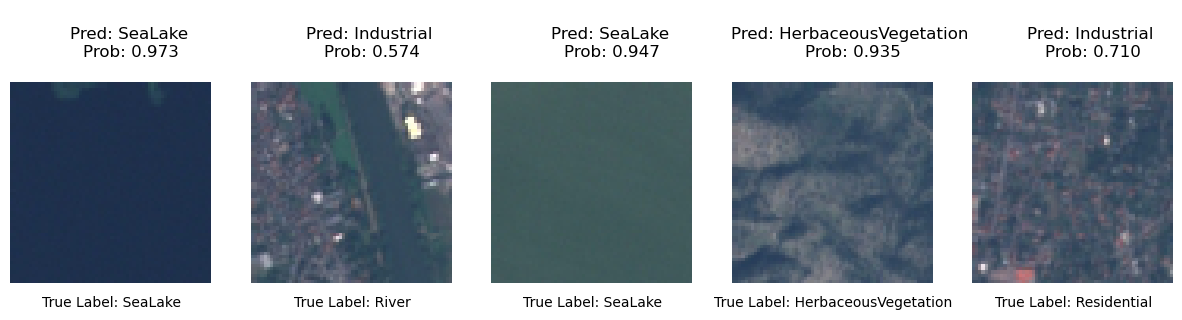

In [16]:
num_images_to_plot = 5
test_image_path_list = list(pathlib.Path(test_path).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
fig = plt.figure(figsize=(15,5))
for position, image_path in enumerate(test_image_path_sample):
    ax = fig.add_subplot(1, num_images_to_plot, position+1)
    utils.pred_and_plot_image(model=model_enb0, 
                        image_path=image_path,
                        class_names=class_name,
                        transform=transform, # optionally pass in a specified transform from our pretrained model weights
                        image_size=(IMG_WIDTH, IMG_HEIGHT)
                        )
    ax.text(32,70, f"True Label: {image_path.parent.name}", ha='center', va='center')

In [17]:
# 1. Make predictions with trained model
y_preds = []
model_enb0.to(device).eval()
with torch.inference_mode():
  for X, y in tqdm(valid_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_enb0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/85 [00:00<?, ?it/s]

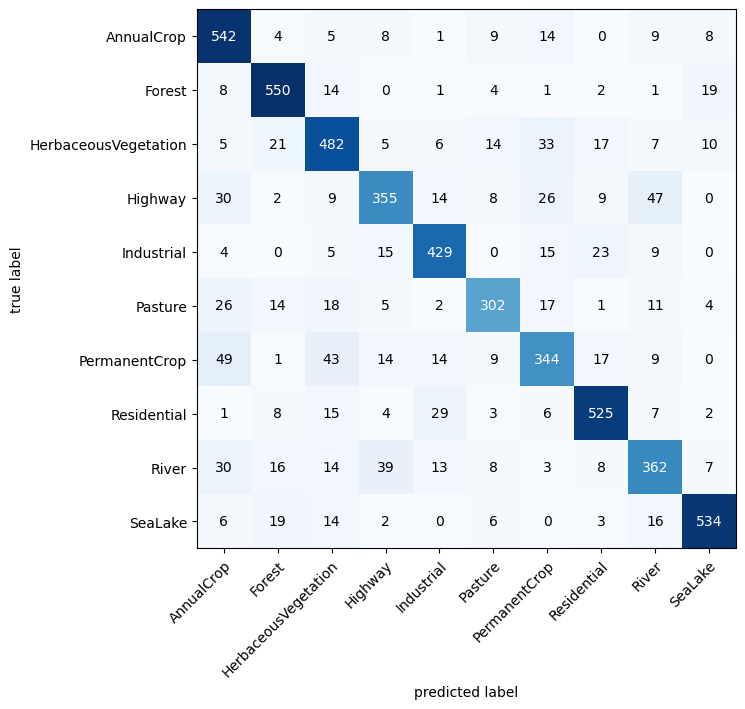

In [18]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_name), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(valid_dataset.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_name, # turn the row and column labels into class names
    figsize=(10, 7)
);

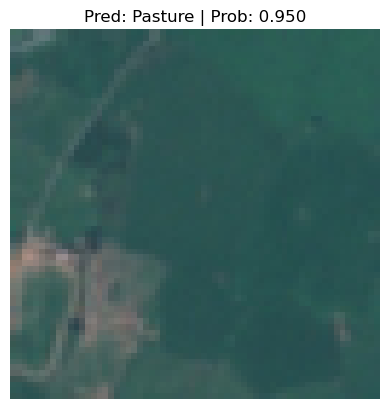

In [19]:
# get randomized index
temp_class = random.choice(class_name)
index = random.randint(0,600)

# open and transform the image
image_path = train_path / temp_class / os.listdir(train_path / temp_class)[index]
img = Image.open(image_path)
image_transform = transform
transformed_image = image_transform(img).unsqueeze(dim=0)

# make a prediction
target_image_pred = model_enb0(transformed_image.to(device))
target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
target_image_pred_label

# plot the image
plt.figure()
plt.imshow(img)
plt.title(f"Pred: {class_name[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
plt.axis(False);

## ResNet

In [21]:
def create_resnet():
    model_resnet = torchvision.models.resnet34(weights='DEFAULT').to(device)

    for param in model_resnet.parameters():
        param.requires_grad = False

    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_name)

    # Recreate the classifier layer and seed it to the target device
    in_features = model_resnet.fc.in_features
    model_resnet.fc = torch.nn.Linear(
        in_features=in_features,
        out_features=output_shape, # same number of output units as our number of classes
        ).to(device)
    
    return model_resnet

### Training Process

In [22]:
# Define the transformation for the dataset
train_resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

valid_resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

resnet_train_dataset = datasets.ImageFolder(root=train_path, transform=train_resnet_transform)
resnet_train_loader = DataLoader(resnet_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

resnet_valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_resnet_transform)
resnet_valid_loader = DataLoader(resnet_valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
model_resnet = create_resnet()

In [24]:
# Define loss and optimizer
resnet_loss_fn = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

In [ ]:
# Setup training and save the results
EPOCH = 5

results_resnet = engine.train(
    model=model_resnet,
    train_dataloader=resnet_train_loader,
    test_dataloader=resnet_valid_loader,
    optimizer=resnet_optimizer,
    loss_fn=resnet_loss_fn,
    epochs=EPOCH,
    device=device)

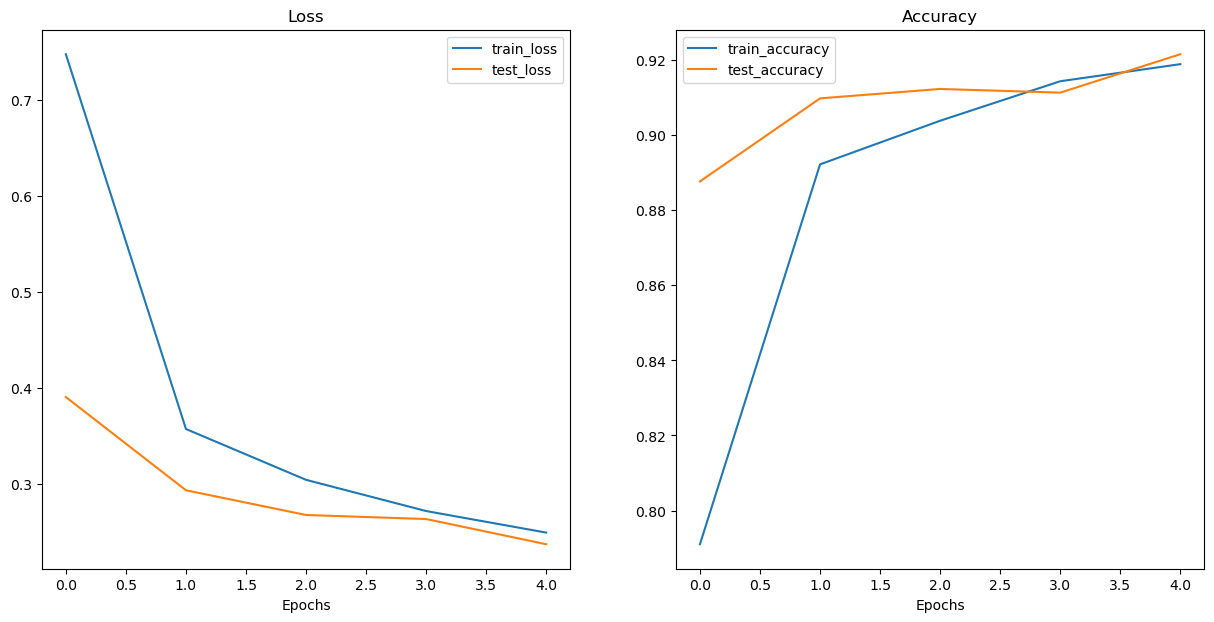

In [23]:
utils.plot_loss_curves(results_resnet)

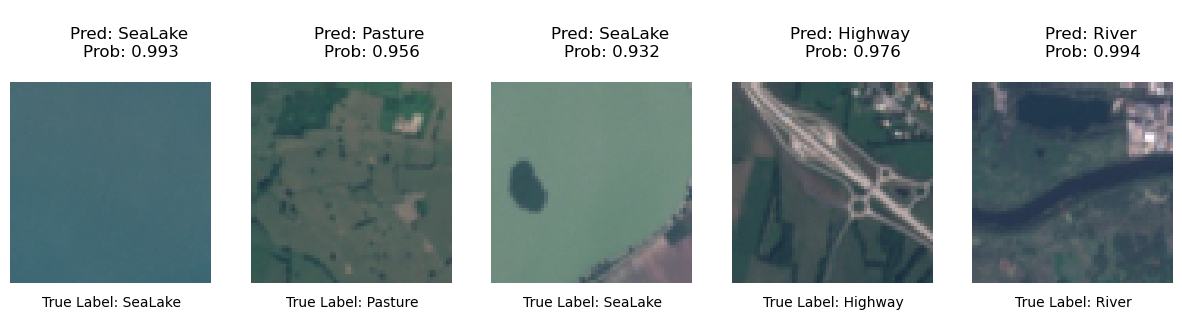

In [27]:
num_images_to_plot = 5
test_image_path_list = list(pathlib.Path(test_path).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
fig = plt.figure(figsize=(15,5))
for position, image_path in enumerate(test_image_path_sample):
    ax = fig.add_subplot(1, num_images_to_plot, position+1)
    utils.pred_and_plot_image(model=model_resnet, 
                        image_path=image_path,
                        class_names=class_name,
                        transform=train_resnet_transform, # optionally pass in a specified transform from our pretrained model weights
                        image_size=(IMG_WIDTH, IMG_HEIGHT)
                        )
    ax.text(32,70, f"True Label: {image_path.parent.name}", ha='center', va='center')

# Experiment Tracking

## Tensorboard

In [25]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/eurosat")

In [26]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [27]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "resnet34"]

In [28]:
# # 1. Set the random seeds
# set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# # 3. Loop through each DataLoader
# for dataloader_name, train_dataloader in train_dataloaders.items():

# 4. Loop through each number of epochs
for epochs in num_epochs: 

    # 5. Loop through each model name and create a new model based on the name
    for model_name in models:

        # 6. Create information print outs
        experiment_number += 1
        print(f"[INFO] Experiment number: {experiment_number}")
        print(f"[INFO] Model: {model_name}")
        # print(f"[INFO] DataLoader: {dataloader_name}")
        print(f"[INFO] Number of epochs: {epochs}")  

        # 7. Select the model
        if model_name == "effnetb0":
            model = create_enb0() # creates a new model each time (important because we want each experiment to start from scratch)
            train_dataloader = train_loader
            test_dataloader = valid_loader
        else:
            model = create_resnet() # creates a new model each time (important because we want each experiment to start from scratch)
            train_dataloader = resnet_train_loader
            test_dataloader = resnet_valid_loader
        
        # 8. Create a new loss and optimizer for every model
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        # 9. Train target model with target dataloaders and track experiments
        engine.train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader, 
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer=create_writer(experiment_name="eurosat",
                                    model_name=model_name,
                                    extra=f"{epochs}_epochs"))

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs\2023-07-31\eurosat\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9187 | train_acc: 0.7192 | test_loss: 0.6776 | test_acc: 0.7944
Epoch: 2 | train_loss: 0.6418 | train_acc: 0.7881 | test_loss: 0.7220 | test_acc: 0.8136
Epoch: 3 | train_loss: 0.6020 | train_acc: 0.8030 | test_loss: 0.5650 | test_acc: 0.8068
Epoch: 4 | train_loss: 0.5847 | train_acc: 0.8049 | test_loss: 0.5535 | test_acc: 0.8124
Epoch: 5 | train_loss: 0.5759 | train_acc: 0.8069 | test_loss: 0.5399 | test_acc: 0.8206
[INFO] Experiment number: 2
[INFO] Model: resnet34
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs\2023-07-31\eurosat\resnet34\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7478 | train_acc: 0.7910 | test_loss: 0.3905 | test_acc: 0.8877
Epoch: 2 | train_loss: 0.3572 | train_acc: 0.8922 | test_loss: 0.2933 | test_acc: 0.9098
Epoch: 3 | train_loss: 0.3042 | train_acc: 0.9039 | test_loss: 0.2676 | test_acc: 0.9123
Epoch: 4 | train_loss: 0.2717 | train_acc: 0.9144 | test_loss: 0.2634 | test_acc: 0.9113
Epoch: 5 | train_loss: 0.2492 | train_acc: 0.9189 | test_loss: 0.2371 | test_acc: 0.9216
[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs\2023-07-31\eurosat\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9187 | train_acc: 0.7192 | test_loss: 0.6776 | test_acc: 0.7944
Epoch: 2 | train_loss: 0.6418 | train_acc: 0.7881 | test_loss: 0.7220 | test_acc: 0.8136
Epoch: 3 | train_loss: 0.6020 | train_acc: 0.8030 | test_loss: 0.5650 | test_acc: 0.8068
Epoch: 4 | train_loss: 0.5847 | train_acc: 0.8049 | test_loss: 0.5535 | test_acc: 0.8124
Epoch: 5 | train_loss: 0.5759 | train_acc: 0.8069 | test_loss: 0.5399 | test_acc: 0.8206
Epoch: 6 | train_loss: 0.5754 | train_acc: 0.8060 | test_loss: 0.5580 | test_acc: 0.8241
Epoch: 7 | train_loss: 0.5710 | train_acc: 0.8068 | test_loss: 0.5439 | test_acc: 0.8256
Epoch: 8 | train_loss: 0.5634 | train_acc: 0.8074 | test_loss: 0.7930 | test_acc: 0.8057
Epoch: 9 | train_loss: 0.5630 | train_acc: 0.8098 | test_loss: 0.5616 | test_acc: 0.8200
Epoch: 10 | train_loss: 0.5697 | train_acc: 0.8104 | test_loss: 0.5559 | test_acc: 0.8169
[INFO] Experiment number: 4
[INFO] Model: resnet34
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7478 | train_acc: 0.7910 | test_loss: 0.3905 | test_acc: 0.8877
Epoch: 2 | train_loss: 0.3572 | train_acc: 0.8922 | test_loss: 0.2933 | test_acc: 0.9098
Epoch: 3 | train_loss: 0.3042 | train_acc: 0.9039 | test_loss: 0.2676 | test_acc: 0.9123
Epoch: 4 | train_loss: 0.2717 | train_acc: 0.9144 | test_loss: 0.2634 | test_acc: 0.9113
Epoch: 5 | train_loss: 0.2492 | train_acc: 0.9189 | test_loss: 0.2371 | test_acc: 0.9216
Epoch: 6 | train_loss: 0.2420 | train_acc: 0.9178 | test_loss: 0.2364 | test_acc: 0.9228
Epoch: 7 | train_loss: 0.2305 | train_acc: 0.9230 | test_loss: 0.2216 | test_acc: 0.9272
Epoch: 8 | train_loss: 0.2260 | train_acc: 0.9240 | test_loss: 0.2279 | test_acc: 0.9219
Epoch: 9 | train_loss: 0.2099 | train_acc: 0.9301 | test_loss: 0.2217 | test_acc: 0.9239
Epoch: 10 | train_loss: 0.2090 | train_acc: 0.9310 | test_loss: 0.2227 | test_acc: 0.9250


tensorboard --logdir=runs/2023-07-31/eurosat --host localhost --port 8088

## MLFlow